In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_genetic.plots import plot_fitness_evolution

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn import decomposition
from sklearn_genetic import GAFeatureSelectionCV

### Load Data

In [13]:
# load data
tr = np.loadtxt('../dataset/baseIAM/treino_baseIAM_301_Filter_1x1_new2.txt')
X_train = tr[:, 0 : -1]
y_train = tr[:, -1]

ts = np.loadtxt('../dataset/baseIAM/teste_baseIAM_301_Filter_1x1_new2.txt')
X_test  = ts[:, 0 : -1]
y_test  = ts[:, -1]

# Normaliza os dados...
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [14]:
def test_classifiers(X_train, X_test, y_train, y_test):
    ### k-NN
    clf = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('kNN', accuracy_score(y_test, y_pred))

    ### Decision Tree
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('DTC', accuracy_score(y_test, y_pred))

    ### SVM
    clf = SVC(probability=True, kernel='rbf')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('SVM', accuracy_score(y_test, y_pred))

    ### MLP
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('MLP', accuracy_score(y_test, y_pred))

    ### RFC
    clf = RandomForestClassifier(n_estimators=1000, max_depth=30)
    clf.fit(X_train, y_train)  
    y_pred = clf.predict(X_test)
    print('RFC', accuracy_score(y_test, y_pred))

### Base Não Reduzida

In [15]:
test_classifiers(X_train, X_test, y_train, y_test)

kNN 0.6365448504983389
DTC 0.3129568106312292
SVM 0.706312292358804
MLP 0.5681063122923588


KeyboardInterrupt: 

### Base Reduzida Com PCA

In [ ]:
n_components = [16, 32, 64, 128, 256, 512]

for n in n_components:
    #build PCA
    pca = decomposition.PCA(n)
    pca.fit(X_train)

    #fit
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)

    #test
    print('------------------ PCA {n} ------------------')
    test_classifiers(X_train_pca, X_test_pca, y_train, y_test)
    print()

### Base Reduzida Com AG

gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	0.678494	0.00825322 	0.698782   	0.66076    
1  	100   	0.684437	0.00736728 	0.700628   	0.669989   
2  	100   	0.6857  	0.00774918 	0.702842   	0.674788   
3  	100   	0.68722 	0.0069026  	0.702842   	0.674049   
4  	100   	0.688431	0.00691582 	0.702842   	0.676264   
5  	100   	0.687575	0.00784829 	0.702842   	0.674049   
6  	100   	0.689   	0.00871366 	0.703212   	0.674788   
7  	100   	0.690919	0.00827672 	0.705426   	0.671835   
8  	100   	0.692189	0.00932223 	0.705795   	0.675526   
9  	100   	0.690757	0.0109807  	0.710594   	0.665928   
10 	100   	0.694825	0.0104495  	0.710594   	0.665928   
GA Accuracy: 0.6006644518272425


/home/caio/.local/lib/python3.10/site-packages/sklearn_genetic/plots.py:48: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=range(len(estimator)), y=fitness_history, markers=True, palette=palette)


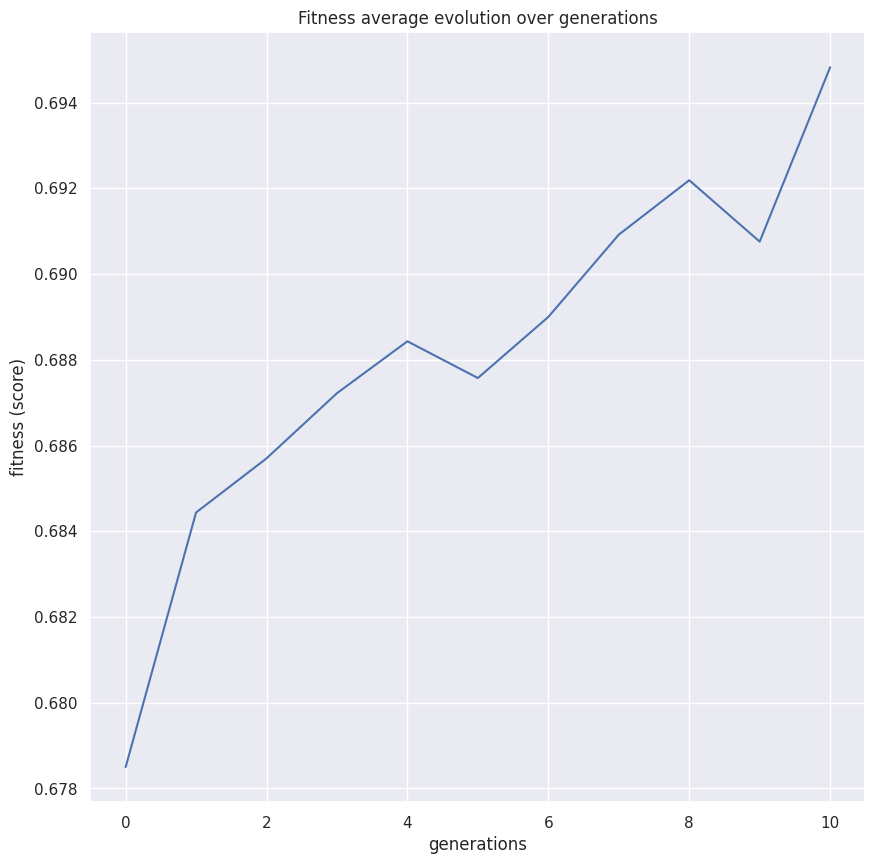

In [ ]:
clf = KNeighborsClassifier(n_neighbors=3, metric='euclidean')

evolved_estimator = GAFeatureSelectionCV(
    estimator=clf,
    cv=3,
    scoring="accuracy",
    population_size=50,
    generations=20,
    n_jobs=-1,
    keep_top_k=5,
    elitism=True,
)

evolved_estimator.fit(X_train, y_train)

# Predict only with the subset of selected features
y_predict_ga = evolved_estimator.predict(X_test)
print('GA Accuracy:', accuracy_score(y_test, y_predict_ga))
    
#plot
plot_fitness_evolution(evolved_estimator)
# plt.savefig("genetico.png") 
plt.show()

In [ ]:
X_train_ga = evolved_estimator.transform(X_train)
X_test_ga = evolved_estimator.transform(X_test)
print(X_train_ga.shape, X_test_ga.shape)

test_classifiers(X_train_ga, X_test_ga, y_train, y_test)

(1505, 1216)
(1505, 618)


### Combinação de Classificadores

In [ ]:
# Caracteristicas
X_tr, y_tr = X_train_ga, y_train
X_te, y_te = X_test_ga, y_test

knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
svm = SVC(probability=True, kernel='rbf')
mlp = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20))
dtc = DecisionTreeClassifier()

# Regra da Soma
# voting = hard -> uses predicted class labels for majority rule voting
clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('mlp', mlp), ('dtc', dtc)], voting='hard')
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_tr)
print('SOMA', accuracy_score(y_te, y_pred))

# Regra do Maximo
# voting = soft -> predicts the class label based on the argmax of the sums of the predicted probabilities,
clf = VotingClassifier(estimators=[('knn', knn), ('svm', svm), ('mlp', mlp), ('dtc', dtc)], voting='soft')
clf.fit(X_tr, y_tr)
y_pred = clf.predict(X_tr)
print('MAXIMO', accuracy_score(y_te, y_pred))

# Regra do Produto